# Démonstration Astropy

Nous présentons ici quelques possibilités de la bibliothèque [Astropy](http://www.astropy.org/).

**Référence:** cette démonstration est très largement inspirée de la partie `Astropy` du cours [Python Euclid 2016](https://github.com/aboucaud/python-euclid2016).

In [1]:
import numpy as N
import matplotlib.pyplot as P
try:
    import seaborn
    seaborn.set_color_codes()  # Override default matplotlib colors 'b', 'r', 'g', etc.
except ImportError:
    pass

# Interactive figures
# %matplotlib notebook
# Static figures
%matplotlib inline

## Fichiers FITS

Le format [FITS](https://fits.gsfc.nasa.gov/) (*Flexible Image Transport System*) constitue le format de données historique (et encore très utilisé) de la communauté astronomique.  Il permet le stockage simultané de données -- sous forme de tableaux numériques multidimensionnels (spectre 1D, image 2D, cube 3D, etc.) ou de tables de données structurées (texte ou binaires) -- et des métadonnées associées -- sous la forme d'un entête ASCII nommé *header*.  Il autorise en outre de combiner au sein d'un même fichier différents segments de données (*extensions*, p.ex. le signal et la variance associée) sous la forme de HDU (*Header-Data Units*).

Le fichier FITS de test est disponible ici: [image.fits](image.fits) (données *Herschel Space Observatory*)

### Lire un fichier FITS

In [2]:
from astropy.io import fits as F

filename = "image.fits"
hdulist = F.open(filename)

`hdulist` est un objet [HDUList](http://docs.astropy.org/en/stable/io/fits/api/hdulists.html#hdulist) de type liste regroupant les différents HDU du fichier:

In [3]:
hdulist.info()

Filename: image.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     151   ()      
  1  image         1 ImageHDU        52   (273, 296)   float64   
  2  error         1 ImageHDU        20   (273, 296)   float64   
  3  coverage      1 ImageHDU        20   (273, 296)   float64   
  4  History       1 ImageHDU        23   ()      
  5  HistoryScript    1 BinTableHDU     39   105R x 1C   [300A]   
  6  HistoryTasks    1 BinTableHDU     46   77R x 4C   [1K, 27A, 1K, 9A]   
  7  HistoryParameters    1 BinTableHDU     74   614R x 10C   [1K, 20A, 7A, 46A, 1L, 1K, 1L, 74A, 11A, 41A]   


Chaque HDU contient:

* un attribut `data` pour la partie *données* sous la forme d'un `numpy.array` ou d'une structure équivalente à un tableau à type structuré; 
* un attribut `header` pour la partie *métadonnées* sous la forme "`KEY = value / comment`".

In [4]:
imhdu = hdulist['image']
print(type(imhdu.data), type(imhdu.header))

<class 'numpy.ndarray'> <class 'astropy.io.fits.header.Header'>


Il est également possible de lire *directement* les données et les métadonnées de l'extension `image`:

In [5]:
ima, hdr = F.getdata(filename, 'image', header=True)
print(type(ima), type(hdr))

<class 'numpy.ndarray'> <class 'astropy.io.fits.header.Header'>


`data` contient donc les données numériques, ici un tableau 2D:

In [6]:
N.info(ima)

class:  ndarray
shape:  (296, 273)
strides:  (2184, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7fc7b6551ec0
byteorder:  big
byteswap:  True
type: >f8


L'entête `hdr` est un objet de type [Header](http://astropy.readthedocs.io/en/stable/io/fits/api/headers.html#astropy.io.fits.Header) similaire à un `OrderedDict` (dictionnaire ordonné).

In [7]:
hdr[:5]  # Les 5 premières clés de l'entête

XTENSION= 'IMAGE   '           / Java FITS: Wed Aug 14 11:37:21 CEST 2013       
BITPIX  =                  -64                                                  
NAXIS   =                    2 / Dimensionality                                 
NAXIS1  =                  273                                                  
NAXIS2  =                  296                                                  

**Attention:** les axes des tableaux FITS et NumPy arrays sont inversés!

In [8]:
print("FITS: ", (hdr['naxis1'], hdr['naxis2']))  # format de l'image FITS
print("Numpy:", ima.shape)                       # format du tableau numpy

FITS:  (273, 296)
Numpy: (296, 273)


### World Coordinate System

L'entête d'un fichier FITS peut notamment inclure une description détaillée du système de coordonnées lié aux données, le [World Coordinate System](http://astropy.readthedocs.io/en/stable/wcs/index.html).

In [9]:
from astropy import wcs as WCS

wcs = WCS.WCS(hdr)  # Décrypte le WCS à partir de l'entête
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 30.07379502155236  -24.903630299920962  
CRPIX : 134.0  153.0  
NAXIS : 273  296


In [10]:
ra, dec = wcs.wcs_pix2world(0, 0, 0)  # Coordonnées réelles du px (0, 0)
print("World:", ra, dec)
x, y = wcs.wcs_world2pix(ra, dec, 0)  # Coordonnées dans l'image de la position (ra, dec)
print("Image:", x, y)

World: 30.31868700299246 -25.156760607162152
Image: -3.211653165635653e-12 -1.0516032489249483e-12


### Visualisation dans matplotlib

Les tableaux 2D (*image*) se visualisent à l'aide de la commande `imshow`:

- `cmap`: table des couleurs;
- `vmin`, `vmax`: valeurs minimale et maximale des données visualisées;
- `origin`: position du pixel (0, 0) ('lower' = en bas à gauche).

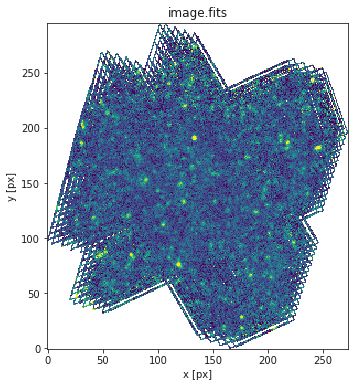

In [11]:
fig, ax = P.subplots(figsize=(6, 6))
ax.imshow(ima, cmap='viridis', origin='lower', interpolation='None', vmin=-2e-2, vmax=5e-2)
ax.set_xlabel("x [px]")
ax.set_ylabel("y [px]")
ax.set_title(filename);

Il est possible d'ajouter d'autres systèmes de coordonnées via WCS.

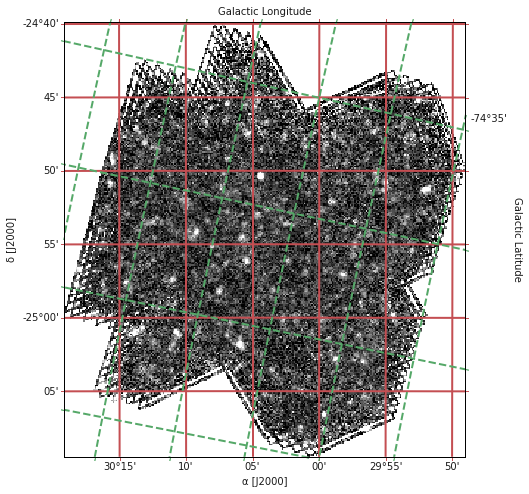

In [12]:
import astropy.visualization as VIZ
from astropy.visualization.mpl_normalize import ImageNormalize

fig = P.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=wcs)

# 10th and 99th percentiles
vmin, vmax = VIZ.AsymmetricPercentileInterval(10, 99).get_limits(ima)
# Linear normalization
norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=VIZ.LinearStretch())

ax.imshow(ima, cmap='gray', origin='lower', interpolation='None', norm=norm)

# Coordonnées équatoriales en rouge
ax.coords['ra'].set_axislabel(u'α [J2000]')
ax.coords['dec'].set_axislabel(u'δ [J2000]')

ax.coords['ra'].set_ticks(color='r')
ax.coords['dec'].set_ticks(color='r')

ax.coords.grid(color='r', ls='-', lw=2)

# Coordonnées galactiques en vert
overlay = ax.get_coords_overlay('galactic')

overlay['l'].set_axislabel('Galactic Longitude')
overlay['b'].set_axislabel('Galactic Latitude')

overlay['l'].set_ticks(color='g')
overlay['b'].set_ticks(color='g')

overlay.grid(color='g', ls='--', lw=2)

## Tables

Outre les tables FITS, `astropy` permet lire et écrire des [Tables](http://astropy.readthedocs.io/en/stable/table/index.html) dans de nombreux [formats ASCII](http://astropy.readthedocs.io/en/stable/io/ascii/index.html#id1) usuels en astronomie (LaTeX, HTML, CDS, SExtractor, etc.).

Le fichier ASCII de test est disponible ici: [sources.dat](sources.dat)

In [13]:
from astropy.io import ascii

catalog = ascii.read('sources.dat')
catalog.info()

<Table length=167>
    name      dtype 
------------ -------
          ra float64
         dec float64
           x float64
           y float64
   raPlusErr float64
  decPlusErr float64
  raMinusErr float64
 decMinusErr float64
    xPlusErr float64
    yPlusErr float64
   xMinusErr float64
   yMinusErr float64
        flux float64
 fluxPlusErr float64
fluxMinusErr float64
  background float64
   bgPlusErr float64
  bgMinusErr float64
     quality float64


In [14]:
catalog.sort('flux')  # Ordonne les sources par 'flux' croissant
catalog.reverse()     # Ordonne les sources par 'flux' décroissant

#catalog.show_in_notebook(display_length=5)
catalog[:5]           # Les cinq sources les plus brillantes du catalogue

ra,dec,x,y,raPlusErr,decPlusErr,raMinusErr,decMinusErr,xPlusErr,yPlusErr,xMinusErr,yMinusErr,flux,fluxPlusErr,fluxMinusErr,background,bgPlusErr,bgMinusErr,quality
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
30.0736543481,-24.8389847181,133.076596062,190.787365523,0.000137260656107,0.000124562849667,0.000137260656103,0.000124562850274,0.0747378051241,0.0747378051241,0.0747378051241,0.0747378051241,157.862010775,6.55458899877,6.55458899877,-0.00492962840045,0.00280563968109,0.00280563968109,24.0841967062
30.0997563127,-25.030193106,118.886083699,76.0608399428,0.000200560356177,0.00018172429472,0.000200560356813,0.000181724292183,0.109035119289,0.109035119289,0.109035119289,0.109035119289,118.448614593,7.17503267878,7.17503267878,0.00226922676457,0.00310958937187,0.00310958937187,16.5084425251
30.2726211379,-25.0771584874,24.9485847511,47.803308157,0.000495906932571,0.000449161858974,0.00049590696235,0.000449161837629,0.269501203678,0.269501203678,0.269501203678,0.269501203678,115.452316575,17.2858546025,17.2858546025,0.0108994941326,0.00603800958334,0.00603800958334,6.67900541976
29.8763509609,-24.7518860739,240.583543382,242.969136003,0.000363715086376,0.000330300804947,0.000363715070463,0.000330300815023,0.198183052816,0.198183052816,0.198183052816,0.198183052816,95.2024034098,10.4819460796,10.4819460796,-0.0013197765479,0.00466051306854,0.00466051306854,9.08251222505
29.8668948822,-24.8539846811,245.642862323,181.701895847,0.000391871197269,0.000355578581107,0.000391871177911,0.000355578584919,0.213348701017,0.213348701017,0.213348701017,0.213348701017,73.0101287468,8.65367562734,8.65367562734,0.0147626682141,0.00330155226713,0.00330155226713,8.43689223988


Histogramme des flux, avec [choix automatique](http://docs.astropy.org/en/stable/visualization/histogram.html) du nombre de *bins*:

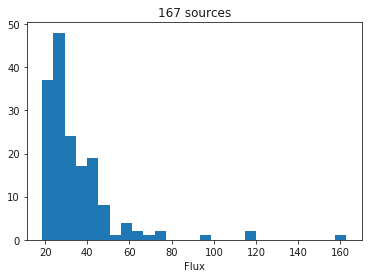

In [15]:
import astropy.visualization as VIZ

fig, ax = P.subplots()
VIZ.hist(catalog['flux'], bins='freedman', ax=ax, histtype='stepfilled')
ax.set(xlabel="Flux", title="%d sources" % len(catalog));

Après conversion des coordonnées RA-Dec de la table en coordonnées, on peut superposer la position des 5 sources les plus brillantes du catalogue à l'image précédente:

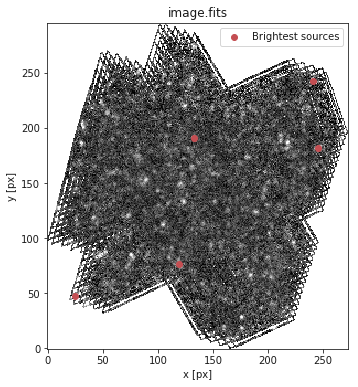

In [16]:
fig, ax = P.subplots(figsize=(6, 6))
ax.imshow(ima, cmap='gray', origin='lower', interpolation='None', vmin=-2e-2, vmax=5e-2)
ax.set(xlabel="x [px]", ylabel="y [px]", title=filename)

x, y = wcs.wcs_world2pix(catalog['ra'][:5], catalog['dec'][:5], 0)
ax.scatter(x, y, color='r', label="Brightest sources")
ax.legend();

## Quantités et unités

Astropy permet de définir des [Quantités](http://astropy.readthedocs.io/en/stable/api/astropy.units.Quantity.html) *dimensionnées* et de gérer les conversions d'unités.

In [17]:
from astropy import units as U
from astropy import constants as K

print("Vitesse de la lumière: {:.9g} = {:.9g}".format(K.c, K.c.to("Mpc/Ga")))

Vitesse de la lumière: 299792458 m / s = 306.601394 Mpc / Ga


In [18]:
H0 = 70 * U.km / U.s / U.Mpc
print ("H0 = {:.1f} = {:.1f} = {:.1f} = {:.3g}".format(H0, H0.to("nm/(a*km)"), H0.to("Mpc/(Ga*Gpc)"), H0.decompose()))

H0 = 70.0 km / (Mpc s) = 71.6 nm / (a km) = 71.6 Mpc / (Ga Gpc) = 2.27e-18 1 / s


In [19]:
l = 100 * U.micron
print("{} = {}".format(l, l.to(U.GHz, equivalencies=U.spectral())))

s = 1 * U.mJy
print ("{} = {} à {}".format(s, s.to('erg/(cm**2 * s * angstrom)', 
                                     equivalencies=U.spectral_density(1 * U.micron)), 1 * U.micron))

100.0 micron = 2997.9245800000003 GHz
1.0 mJy = 2.997924580000001e-16 erg / (Angstrom cm2 s) à 1.0 micron


## Calculs cosmologiques

Astropy permet des calculs de base de [cosmologie](http://astropy.readthedocs.io/en/stable/cosmology/index.html).

In [20]:
from astropy.cosmology import Planck15 as cosmo
print(cosmo)

FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[ 0.    0.    0.06] eV, Ob0=0.0486)


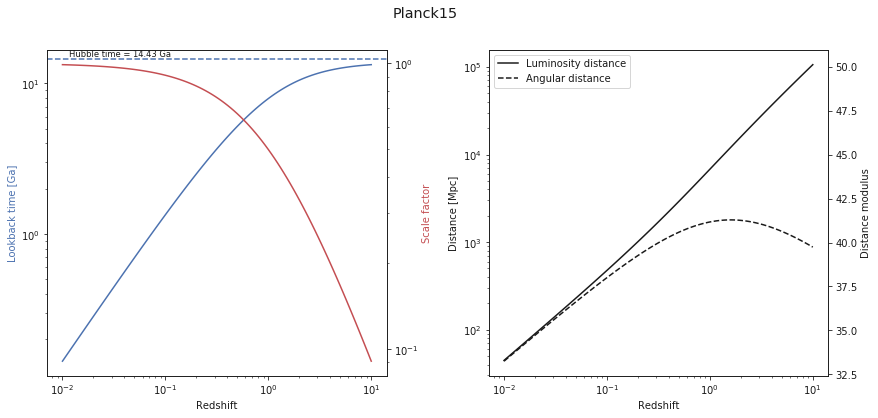

In [21]:
z = N.logspace(-2, 1, 100)

fig = P.figure(figsize=(14, 6))

# Ax1: lookback time
ax1 = fig.add_subplot(1, 2, 1, 
                      xlabel="Redshift", xscale='log')
ax1.plot(z, cosmo.lookback_time(z), 'b-')
ax1.set_ylabel("Lookback time [Ga]", color='b')
ax1.set_yscale('log')

ax1.xaxis.set_minor_locator(P.matplotlib.ticker.LogLocator(subs=range(2,10)))
ax1.yaxis.set_minor_locator(P.matplotlib.ticker.LogLocator(subs=range(2,10)))
ax1.grid(which='minor', color='w', linewidth=0.5)

# En parallèle: facteur d'échelle
ax1b = ax1.twinx()
ax1b.plot(z, cosmo.scale_factor(z), 'r-')
ax1b.set_ylabel("Scale factor", color='r')
ax1b.set_yscale('log')
ax1b.grid(False)

ht = (1/cosmo.H0).to('Ga')  # Hubble time
ax1.axhline(ht.value, c='b', ls='--')
ax1.annotate("Hubble time = {:.2f}".format(ht), (z[1], ht.value), (3,3),
             textcoords='offset points', size='small');

# Ax2: distances de luminosité et angulaire
ax2 = fig.add_subplot(1, 2, 2, 
                      xlabel="Redshift", xscale='log')
ax2.plot(z, cosmo.luminosity_distance(z), 'k-', label="Luminosity distance")
ax2.plot(z, cosmo.angular_diameter_distance(z), 'k--', label="Angular distance")
ax2.set_ylabel("Distance [Mpc]")
ax2.set_yscale('log')
ax2.legend()

ax2.xaxis.set_minor_locator(P.matplotlib.ticker.LogLocator(subs=range(2,10)))
ax2.yaxis.set_minor_locator(P.matplotlib.ticker.LogLocator(subs=range(2,10)))
ax2.grid(which='minor', color='w', linewidth=0.5)

# En parallèle, module de distance
ax2b = ax2.twinx()
ax2b.plot(z, cosmo.distmod(z), 'k-', visible=False)  # Just to get the scale
ax2b.set_ylabel("Distance modulus")

fig.subplots_adjust(wspace=0.3)
fig.suptitle(cosmo.name, fontsize='x-large');